# 5. Surprise 패키지 사용

## 5.1 Surprise 기본 활용 방법

In [1]:
import matplotlib.pyplot as plt

In [15]:
import numpy as np

# 사용자의 평점 평균과 아이템의 평점평균을 모델화해서 예측하는 알고리즘
from surprise import BaselineOnly
# 사용자의 평가경향을 포함한 CF 알고리즘
from surprise import KNNWithMeans
# MF 알고리즘
from surprise import SVD
# MF 기반으로 사용자으 ㅣ특정 아이템에 대한 평가여부를 이진값으로 암묵적 평가로 추가한 알고리즘
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from utility import *

In [3]:
# data 불러오기
data = Dataset.load_builtin('ml-100k')

# train/test 분리
trainset, testset = train_test_split(data, test_size = 0.25)

# 정확도 계산
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9568


0.9568123527078372

## 5.2 알고리즘 비교
 - 4가지의 알고리즘 비교

In [4]:
# 알고리즘 비교
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))
names = np.array(names)
results = np.array(results)

Estimating biases using als...
RMSE: 0.9460
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9568
RMSE: 0.9409
RMSE: 0.9237


array([0.92369489, 0.94094723, 0.94603091, 0.95681235])

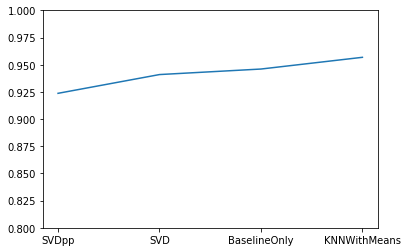

In [5]:
index = np.argsort(results)
plt.ylim(0.8,1)
plt.plot(names[index],results[index])
results[index]

## 5.3 알고리즘 옵션 지정

In [6]:
sim_options = {'name':'pearson_baseline', 'user_based': True}
algo = KNNWithMeans(k=30, sim_options = sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9468


0.9468196675071097

## 5.4 다양한 조건의 비교
 - 최적의 이웃크기를 찾기

In [7]:
result = []
for neighbor_size in [10,20,30,40,50,60]:
    algo = KNNWithMeans(k=neighbor_size, sim_options = sim_options)
    algo.fit(trainset)
    predictions = algo.test(testset)
    result.append([neighbor_size, accuracy.rmse(predictions)])
result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9622
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9488
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9468
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9464
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9464
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9467


[[10, 0.9621794014042125],
 [20, 0.9487866689874094],
 [30, 0.9468196675071097],
 [40, 0.946399540779525],
 [50, 0.9463921978225027],
 [60, 0.9467064415967412]]

In [10]:
param_grid = {'k':[5,10,15,20],
             'sim_options':{'name':['pearson_baseline','cosine'],
                            'user_based':[True, False]}
             }
# cv = cross validation
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 rmse 출력
print(gs.best_score['rmse'])
# 최적 파라미터 출력
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

In [21]:
# MF의 파라미터 변경
param_grid = {'n_epochs':[70,80,90],
              'lr_all':[0.005,0.006,0.007],
              'reg_all' : [0.05,0.07,0.1]
             }
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 rmse 출력
print(gs.best_score['rmse'])

# 최적 파라미터 출력
print(gs.best_params['rmse'])

0.9118568972439814
{'n_epochs': 80, 'lr_all': 0.006, 'reg_all': 0.1}


## 5.5 외부 데이터 사용
 - surprise 패키지에서는 기존 dataframe 사용불가
 - 이를 Reader로 불러와야함

In [16]:
_,_,ratings = getData()

In [19]:
ratings.drop('timestamp',inplace=True, axis=1)
ratings.reset_index(inplace=True)

In [20]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)